In [1]:
from google.colab import drive
drive.mount('/content/drive',force_remount=True)

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [2]:
try:
  %tensorflow_version 2.x
except Exception:
  pass
import tensorflow as tf 
import matplotlib.pyplot as plt
import numpy as np
import os
tf.random.set_seed(42)

TensorFlow 2.x selected.


# Import the Dataset

In [0]:
def record_parser(example):
    example_fmt = {
        'label': tf.io.FixedLenFeature([14], tf.float32),
        'image': tf.io.FixedLenFeature([],tf.string, default_value='')}
    parsed = tf.io.parse_single_example(example, example_fmt)
    image = tf.io.decode_png(parsed["image"],channels=3)
    image = tf.image.convert_image_dtype(image, tf.float32)
    return image, parsed['label']

def normalize_image(img,labels):
    imagenet_mean = np.array([0.485, 0.456, 0.406])
    imagenet_std = np.array([0.229, 0.224, 0.225])
    img = (img - imagenet_mean) / imagenet_std
    return img,labels

def make_dataset(filename):
  base_path = '/content/drive/My Drive/tfrecords'
  full_path = os.path.join(base_path,filename)
  dataset = tf.data.TFRecordDataset(full_path)
  parsed_dataset = dataset.map(record_parser)
  parsed_dataset = parsed_dataset.map(normalize_image)
  return parsed_dataset

batch_size = 64
train_dataset = make_dataset('training_cropped.tfrecords').batch(batch_size, drop_remainder=True).prefetch(1)
val_dataset = make_dataset('validation_cropped.tfrecords').shuffle(buffer_size=128).batch(batch_size, drop_remainder=True).prefetch(1)
test_dataset = make_dataset('test_set_cropped.tfrecords').batch(batch_size, drop_remainder=False).prefetch(1)

# Load the models

In [5]:
from tensorflow.keras.models import load_model

base_path = '/content/drive/My Drive/Models'
def load_models(base_path):
  models = []
  for model in os.listdir(base_path):
    print('loading model: {}'.format(model))
    models.append(load_model(os.path.join(base_path,model)))
  return models

models = load_models(base_path)

loading model: inceptionresnetv2_model.hdf5
loading model: xception_model.hdf5
loading model: densenet121_model.hdf5
loading model: densenet169_model.hdf5
loading model: densenet201_model.hdf5
loading model: nasnetmobile_model.hdf5
loading model: vgg19_model.hdf5
loading model: vgg16_model.hdf5


# Load the image

In [0]:
unbatched_test = test_dataset.unbatch()
test_imgs = []
test_labels = []
for img, labels in unbatched_test:
  test_imgs.append(img.numpy())
  test_labels.append(labels.numpy())
test_imgs = np.array(test_imgs)
test_labels = np.array(test_labels)

def get_img(index):
  return test_imgs[index].reshape(-1,224,224,3)

img_index = 8
img = get_img(img_index)

# Build the Class Activation Map

In [0]:
from tensorflow.keras.models import Model, load_model
import cv2

def build_image_cam(model,last_conv,img,pred): 
  cam_model = Model(inputs=model.input, 
                    outputs=(model.get_layer(last_conv).output, model.layers[-1].output)) 
  #Make the prediction for a set of test images
  features, results = cam_model.predict(img)
  features = features[0,:,:,:]
  #Get the weights of the fully connected layers
  fc_weights = model.layers[-1].get_weights()[0]
  #Get the weights of the fully connected layer for the given prediction
  cam_weights = fc_weights[:, pred]  
  #Create the class activation map
  cam = np.dot(features, cam_weights)
  cam = cv2.resize(cam, (224, 224))
  return cam

def compute_cams(models,label):
  last_conv_name = ['conv_7b_bn','block14_sepconv2_bn','bn','bn','bn','normal_concat_12','block5_pool','block5_pool']
  heatmaps = []
  for i,model in enumerate(models):
    last_conv = last_conv_name[i]
    hm = build_image_cam(model,last_conv, img,label)
    heatmaps.append(hm)
  return heatmaps

def compute_image_predictions(models,img,threeshold=0.3):
  predictions = []
  for model in models:
    predictions.append(model.predict(img))
  predictions = np.array(predictions)
  predictions = (predictions >= threeshold).astype('int').reshape((8,14))
  return predictions

In [0]:
predictions = compute_image_predictions(models,img)

In [0]:
predictions = compute_image_predictions(models,img)

label = 13
positive_pred = np.where(predictions[:,label] == 1)[0]
negative_pred = np.where(predictions[:,label] == 0)[0]

cams = compute_cams(models,label)
positive_pred_cams = np.array(cams)[positive_pred]
negative_pred_cams = np.array(cams)[negative_pred]

# Display the CAMS

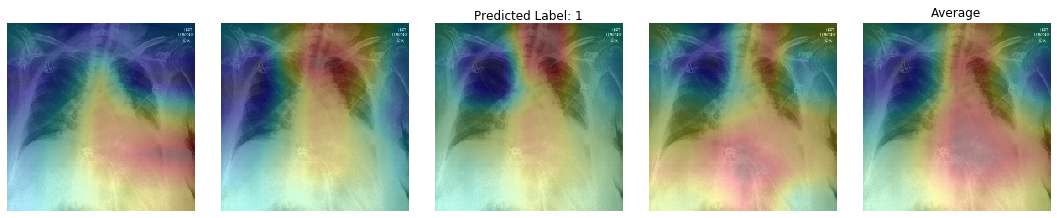

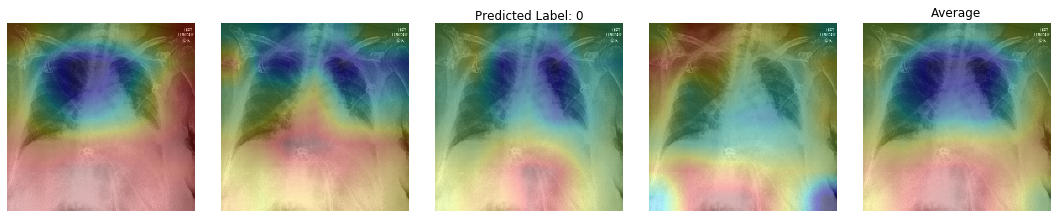

In [34]:
n_rows = 1
n_columns = positive_pred_cams.shape[0] +1
fig = plt.figure(1,figsize=((3*(n_columns),3)))
gs = fig.add_gridspec(1, n_columns)
fig.suptitle('Predicted Label: 1')
for i,cam in enumerate(positive_pred_cams):
  ax = fig.add_subplot(gs[0,i])
  ax.imshow(img[0,:,:,0],alpha=1,cmap='gray')
  ax.imshow(cam, cmap='jet', alpha=0.3)
  ax.axis('off')

ax = fig.add_subplot(n_rows,n_columns,positive_pred_cams.shape[0] + 1)
ax.imshow(img[0,:,:,0],alpha=1,cmap='gray')
ax.imshow(np.average(positive_pred_cams,axis=0), cmap='jet', alpha=0.3)
ax.axis('off')
ax.set_title('Average')
plt.tight_layout()


fig2 = plt.figure(2,figsize=(3*(negative_pred_cams.shape[0] + 1),3))
n_rows = 1
n_columns = negative_pred_cams.shape[0] +1
gs = fig.add_gridspec(1, n_columns)

fig2.suptitle('Predicted Label: 0')
for i,cam in enumerate(negative_pred_cams):
  ax = fig2.add_subplot(gs[0,i])
 # ax = fig2.add_subplot(n_rows,n_columns,i+1)
  ax.imshow(img[0,:,:,0],alpha=1,cmap='gray')
  ax.imshow(cam, cmap='jet', alpha=0.3)
  ax.axis('off')
ax = fig2.add_subplot(n_rows,n_columns,negative_pred_cams.shape[0] + 1)
ax.imshow(img[0,:,:,0],alpha=1,cmap='gray')
ax.imshow(np.average(negative_pred_cams,axis=0), cmap='jet', alpha=0.3)
ax.axis('off')
ax.set_title('Average')
plt.tight_layout()